# Fit BERTopic with k-means clustering

In [1]:
import os
import sys
import logging
from dotenv import load_dotenv

project_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(project_dir)
load_dotenv()

from topicmodeling.data_loading import load_data
from topicmodeling.topic_models import setup_bertopic
from topicmodeling.evaluation import evaluate_bertopic
from topicmodeling.config import BBC_PATH, CATEGORIES, CLUSTERING, EMBEDDING_MODEL_NAME, VERBOSE

In [7]:
# Load BBC Data
articles, labels = load_data(path=BBC_PATH, categories=CATEGORIES, shuffle=True)

# Instantiate BERTopic and pre-compute embeddings
topic_model, article_embeddings, emb_model = setup_bertopic(
    sentences=articles, emb_model_name=EMBEDDING_MODEL_NAME, verbose=VERBOSE, clustering="kmeans"
)

# Fit using pre-computed embeddings
topics, probs = topic_model.fit_transform(documents=articles, embeddings=article_embeddings)

# Evaluate coherence and perplexity
eval_metrics = evaluate_bertopic(model=topic_model, predictions=topics, docs=articles, probabilities=probs)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [8]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,0,792,0_broadband_mobile_tv_media,"[broadband, mobile, tv, media, phones, technol...",[Mobiles 'not media players yet'\n\nMobiles ar...
1,1,480,1_financial_economy_market_investors,"[financial, economy, market, investors, firms,...",[Soaring oil 'hits world economy'\n\nThe soari...
2,2,430,2_mr blair_tony blair_blair_tory,"[mr blair, tony blair, blair, tory, gordon bro...",[Brown in appeal for Labour unity\n\nGordon Br...
3,3,335,3_england_rugby_ireland_wales,"[england, rugby, ireland, wales, irish, refere...",[Sella wants Michalak recall\n\nFormer France ...
4,4,188,4_wimbledon_tennis_hewitt_doping,"[wimbledon, tennis, hewitt, doping, davis cup,...",[Henman to face Saulnier test\n\nBritish numbe...


# Evaluation against known labels

In practice we would not have access to labels, but this can be helpful in analysing what is going on. As we can see in the image below, the model has correctly put largest similarity on `tech`, `finance` and `politics`, however it seems that `sport` has been split into two categories. One possible explanation is that `entertainment` has been split between `tech` and both `sport` topics.

In [9]:
# Concatenate descriptive words into a single str representing the topic and embed them
topics_to_embed = [" ".join([name for name, value in seq]) for ix, seq in topic_model.get_topics().items()]
topics_embeddings = emb_model.encode(topics_to_embed)

In [10]:
# Embed the categories
cat_embeddings = emb_model.encode(CATEGORIES)

In [11]:
# Compute cosine similarities (embedding model uses unit vectors already)
dot_prods = cat_embeddings.dot(topics_embeddings.T)  # cosine similarity

In [12]:
import matplotlib.pyplot as plt

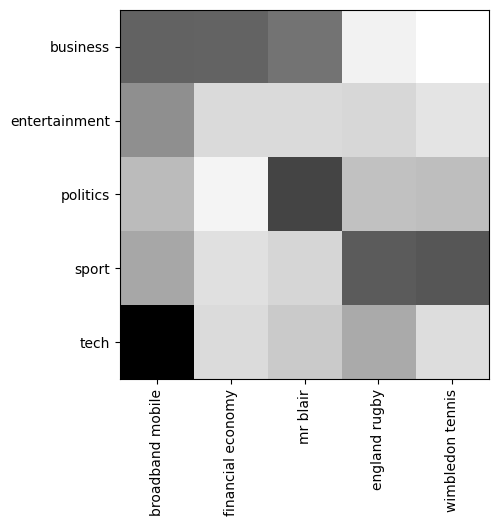

In [13]:
fig, ax = plt.subplots()
ax.imshow(dot_prods, cmap="Greys")
ax.set_yticks(range(len(CATEGORIES)))
ax.set_yticklabels(CATEGORIES)
ax.set_xticks(range(len(CATEGORIES)))
ax.set_xticklabels([" ".join(topic.split()[:2]) for topic in topics_to_embed], rotation=90)
plt.show()